# Exercise Session 2: Convolution, Filtering and Gradients

The goal of this exercise is to:
* Understand and apply a convolutional filter to an image
* Compare the computational complexity of separable and non-separable filters
* Compute image gradients and apply them to real-world images

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import scipy.signal as conv

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.cmap'] = 'gray'

## Exercise 1: Applying Convolutional Filters

Assume we are given a gray-scale image $I[x, y]$, of size $W \times H$, such that $0 \leq x \leq W-1$,
and $0 \leq y \leq H-1$. We want to apply a filter $F[i, j]$ to image $I$. The filter $F$ is of size $(2N + 1) \times (2M + 1)$, such that $−N \leq i \leq N$, and $−M \leq j \leq M$.

The result can be computed as

\begin{align}
R[x, y] = (I ∗ F)[x, y] = \sum_{i=-N}^{N} \sum_{i=-M}^{M} I[x − i, y − j]~F[i, j]
\end{align}


* Implement a function ```R = applyImageFilter(I,F)``` that takes a
gray-scale image $I$ and a filter $F$ as inputs, and returns the result of the convolution
of the two.
Note: There are many python libraries providing convolution function to convolve an image with a filter, 
but in this exercise you are requested to implement your own. This will help your understanding
of how convolutional filters work.
    -  To avoid numerical issues, make sure $I$ and $F$ are of type float. To understand
why, think what would happen if you add two unsigned 8-bit numbers when
computing the convolution, for example 240 and 80.
    -  What happens when computing $R[x, y]$ near the border of the image? What
would you propose to deal with this issue?  

In [2]:
def applyImageFilter(I, F, padding='same'):
    # First input parameter: I
    #     Input image. It should be a 2D matrix. According to the notation in the description, it has W rows and 
    #     H columns.
    # Second input parameter: F
    #     Filter used for the convolution. It should be a 2D matrix. According to the notation in the decription,
    #     it has (2N+1) rows and (2M+1) columns.
    # Third input parameter: padding mode
    #     This is an optional parameter. Default value will be same (i.e. if you only pass I, F parameters
    #     when calling the function, padding will be set to 'same'). The other padding mode is 'valid'
    #     See below in the code for the explanaiton of the two modes. 
    
    # If image is not of type float, convert it to float
    if not np.issubdtype(I.dtype,float):
        I = np.float64(I)
        
    # If the filter is not of type float, convert it to float
    if not np.issubdtype(F.dtype,float):
        F = np.float64(F)
    
    # Shape of Filter
    N_, M_ = F.shape
    
    # Check whether the dimensions of input are accurate, they should be odd
    if not N_%2: 
        raise ValueError('Number of rows in the filter must be odd')
        
    if not M_%2:
        raise ValueError('Number of columns in the filter must be odd')
    
    # Compute the values for N,M which is used in the above description. 
    N = np.int64((N_-1)/2)
    M = np.int64((M_-1)/2)
    
    
    # Shape of the input image
    W, H = I.shape

    
    if padding == 'same': 
        # In this case, the output image size will have same dimensions as the input
        # image (thus the name 'SAME').
        # To achieve this, padding size is determined accordingly
        # The padding enables us to perform convolutions at the bordering pixels. 

        I = np.pad(I, ((N,N),(M,M)), mode='constant') # default value for padding is 0 in np.pad
        # Initialize output image. Note that the size of R is same as the input I
        R = np.zeros((W,H), dtype = np.float64)      
    
    elif padding == 'valid':
        # We can perform convolution without padding the input image as well.
        # In that case, output image size will be (W - 2*N) x (H - 2*M). This type of
        # convolution is called 'valid' convolution in the literature. 

        # Initialize output image
        R = np.zeros((W-2*N,H-2*M), dtype = np.float64)
    else:
        raise ValueError('Unsupported padding type')
    
    # Output image size
    W_R, H_R = R.shape
    
    for x in range(W_R): # iterating through rows of the output image in the direction ↓
        for y in range(H_R): # iterating through columns of the output image in the direction →
            
            # compute the value for R[x, y] 
            # x is the row index
            # y is the column index  
            for i in range(-N,N+1):
                for j in range(-M,M+1):  
                    # I[x+M-j, y+N-i]: I is the padded iamge. 
                    #                 At the x,y iteration, (x,y) corresponds to R[x,y] pixel.
                    #                 This is the location that the filter is centered in this iteration.
                    #                 R[x,y] corresponds to I[x+M, y+N] pixel in I.
                    #                 With the center (x,y), we iterate through it's neighborhood [-N,N] in 
                    #                 x direction and [-M,M] in y direction. 
                    #                 This gives us the coordinates I[x+N-i, y+M-j]
                    # F[i+N,j+M]: F is the filter. In the definition above its indices ranges from 
                    #             -N to N in x direction and -M to M in y direction.
                    #             But the matrix indices are positive, therefore we shift the indices [i+N,j+M].
                    R[x,y] += I[x+N-i, y+M-j]*F[i+N,j+M]
                    
    return R

In [15]:
# Below code is to verify your implementation of the convolution
# we compare your output with the scipy.signal implementation of the convolution
# and the error should be zero

# Read the sample image
img = cv2.imread('images/res1.png',0) 

# Generate a random filter F of size 3 x 3
F = np.random.randn(5,3)

# Perform convolution with the function you implemented
output_1 = applyImageFilter(img, F, padding='same')

# Perform convolution with scipy.signal implementation of convolution
output_2 = conv.convolve2d(img, F , mode='same')

# Error
print(f'Input shape: {img.shape}')
print(f'Output shape: {output_1.shape}')
print(f'Error: {np.sum(np.abs(output_1 - output_2))}')
# if the implmentation is accurate, the error will be 0

Input shape: (390, 476)
Output shape: (390, 476)
Error: 0.0


## Exercise 2: Image Smoothing

Convolutional filters have many uses. A very common one is to smooth or soften an
image. A typical smoothing filter is the Gaussian Filter, which follows the equation of a
2D Gaussian probability distribution. It is an important preprocessing step typically to reduce the amount of noise.  When constructing a Gaussian filter we can specify the size and standard deviation (σ) of the underlying Gaussian function.

* To create a Gaussian filter use the function given below. 

In [16]:
def gaussian_filter(fSize, fSigma):
    x, y = np.mgrid[-fSize//2 + 1:fSize//2 + 1, -fSize//2 + 1:fSize//2 + 1]
    g = np.exp(-((x**2 + y**2)/(2.0*fSigma**2)))
    return g/g.sum()

* What are fSize and fSigma?
* How do fSize and fSigma affect the filter’s shape and size? 
* Visualize different filters by giving different values to these parameters.
* If you are given fSigma, how would you choose fSize?

* Apply Gaussian filtering to 'res1.png'
* To apply the filter to an image use ```cv2.GaussianBlur(img, fSize, fSigma)```
* Experiment with different values of fSigma. How does the amount of smoothing vary with this parameter?

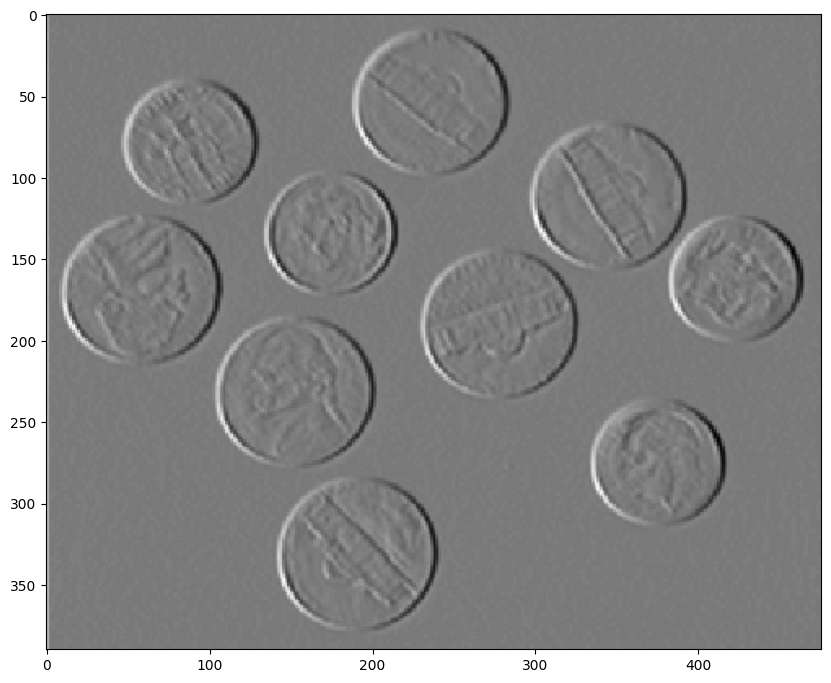

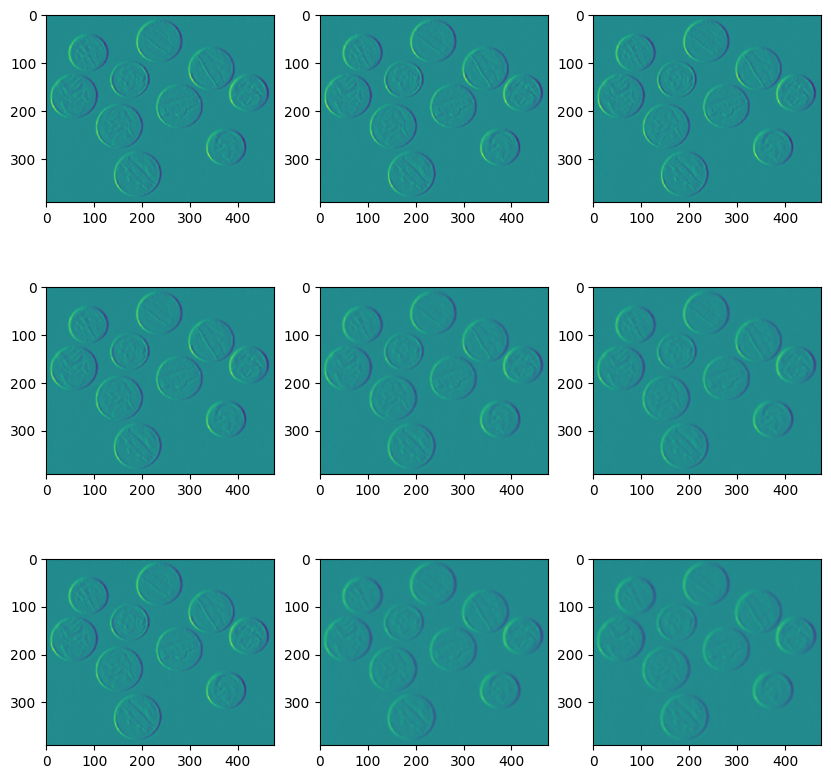

In [17]:
img = cv2.imread('images/res1.png',0)
plt.imshow(img)

# apply filters, try different values of Sigma
### your code here 
sizes = [3, 5, 7]
sigmas = [1, 2.5, 4]
f, axarray = plt.subplots(len(sizes), len(sigmas))
for ind in [(x,y) for x in range(len(sizes)) for y in range(len(sigmas))]:
    sz = sizes[ind[0]]
    axarray[ind].imshow(cv2.GaussianBlur(img, (sz, sz), sigmas[ind[1]]), cmap='viridis', vmin = 0, vmax= 255)

As you saw in the first exercise of this session, applying the filter near the border of
the image is not a well-defined problem. It is possible to deal with this issue through
different approaches. Luckily, cv2.GaussianBlur implements different ways of dealing with border effects.
Here you will try them out and understand what each of them does.

*  Apply a Gaussian filter with fSigma = 10 and fSize = 25 to 'res1.png'
* Use borderType flag of cv2.GaussianBlur function to define what kind of border should be added around the image (cv2.BORDER_CONSTANT, cv2.BORDER_REFLECT, cv2.BORDER_REPLICATE).


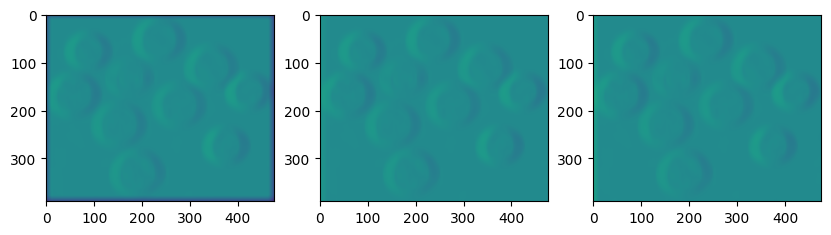

In [18]:
img = cv2.imread('images/res1.png',0)
# apply different border types for blur filters
### your code here
f, axarray = plt.subplots(1, 3)
axarray[0].imshow(cv2.GaussianBlur(img, (25,25), 10, borderType=cv2.BORDER_CONSTANT), cmap='viridis', vmin=0, vmax=255)
axarray[1].imshow(cv2.GaussianBlur(img, (25,25), 10, borderType=cv2.BORDER_REFLECT), cmap='viridis', vmin=0, vmax=255)
axarray[2].imshow(cv2.GaussianBlur(img, (25,25), 10, borderType=cv2.BORDER_REPLICATE), cmap='viridis', vmin=0, vmax=255)

## Exercise 3: Edge detector

Edge detection is one of the most important operations in Computer Vision. In this exercise we will investigate how it
can be performed and what information can be obtained from it.

One of the ways to detect edges is to compute image intensity gradients. They can be approximated by convolving image with Sobel filters. They consist of 2 $3 \times 3$ filters:

\begin{equation*}
S_x = \frac{1}{8}
\begin{bmatrix}
-1 & 0 & +1\\
-2 & 0 & +2\\
-1 & 0 & +1\\
\end{bmatrix}
\hspace{2cm}
S_y = \frac{1}{8}
\begin{bmatrix}
-1 & -2 & -1\\
0 & 0 & 0\\
+1 & +2 & +1\\
\end{bmatrix}
\end{equation*}

where $S_x$ computes the partial derivative of the image in the horizontal direction, while $S_y$ does it in the vertical direction.

* Compute the image derivatives in x- and y-directions using Sobel filters. You can use for that function ```python cv2.Sobel()```

In [7]:
img_coins = cv2.imread('images/coins.png',0)

### Compute gradient in x-direction
### your code here
grad_x = cv2.Sobel(img_coins, cv2.CV_64F, 1, 0, ksize=3)
### Compute gradient in y-direction
### your code here
grad_y = cv2.Sobel(img_coins, cv2.CV_64F, 0, 1, ksize=3)

* Visualize the image gradients. How can you explain the differences between the two results? 

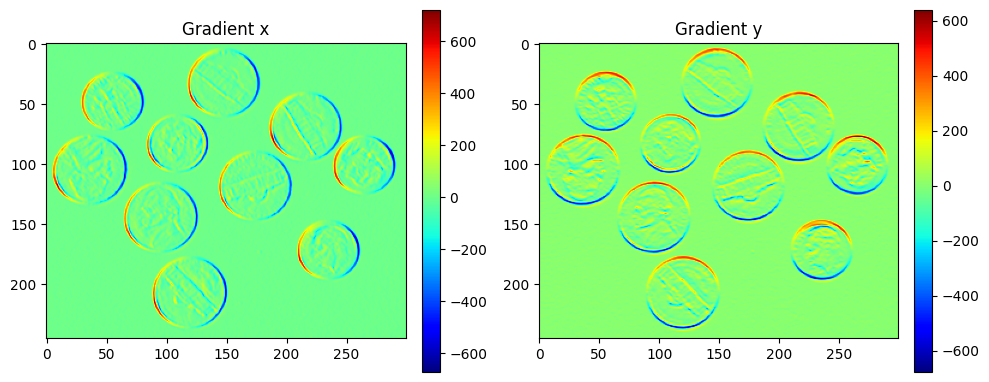

In [8]:
fig = plt.figure()
plt.subplot(1,2,1)
grady = plt.imshow(grad_x,cmap="jet")
plt.title("Gradient x")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1,2,2)
gradx = plt.imshow(grad_y,cmap="jet")
plt.title("Gradient y")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()

Mathematically, the goal of the filters $S_x$ and $S_y$ is to approximate the derivatives of the image with respect to 
the horizontal and vertical directions respectively, such that
\begin{equation*}
\nabla I_x(x,y) = (I*S_x)[x,y]
\quad\mathrm{and}\quad
\nabla I_y(x,y) = (I*S_y)[x,y]
\end{equation*}

Therefore, the gradient of an image at each point is a 2D vector
\begin{equation*}
\nabla I =
\begin{bmatrix}
\nabla I_x\\
\nabla I_y
\end{bmatrix}
\end{equation*}

This vector can be computed for every pixel. Its magnitude and phase can be computed as
\begin{equation*}
|| \nabla I || = \sqrt{(\nabla I_x)^2 + (\nabla I_y)^2} \\
\angle \nabla I = atan2(\nabla I_x, \nabla I_y)
\end{equation*}

$\it{Note:}$ we use atan2() instead of atan() to be able to determine the right quadrant of the phase.

* Using the previously computed image gradients and the above formula compute the gradient magnitude and gradient phase.



In [10]:
### Compute gradient magnitude
### your code here

grad_mag = np.sqrt(np.power(grad_x, 2) + np.power(grad_y, 2))
#
# ### Compute gradient phase
# ### your code here
grad_phase = np.arctan2(grad_x, grad_y)

* Visualize the gradient magnitude and phase images along with the original image. Where does the gradient have high 
magnitude? How does the phase change along the coin border?

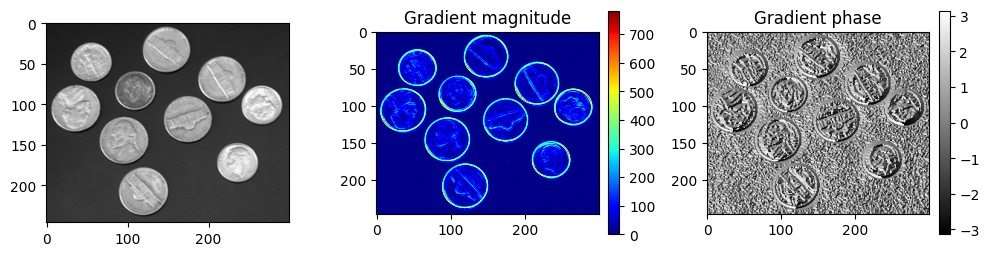

In [11]:
fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(img_coins)
plt.subplot(1,3,2)
grady = plt.imshow(grad_mag,cmap="jet")
plt.title("Gradient magnitude")
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(1,3,3)
gradx = plt.imshow(grad_phase)
plt.title("Gradient phase")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()

The gradient has got the highest magnitude at the borders of the coins. For that reason it can be considered a good 
proxy for detecting edges. The phase of the gradient changes smoothly along the circular coin border along with the 
normal of the boundary.

## Exercise 4: Separable Filters


As seen in class, certain types of 2D filters can be thought of as the composition of two
1-dimensional filters. These are called Separable Filters, and can be computed more
efficiently than those who are non-separable.

For example, the Sobel filter $S_x$ can be decomposed as
 
\begin{equation*} 
\begin{bmatrix}
-1 & 0 & +1\\
-2 & 0 & +2\\
-1 & 0 & +1\\
\end{bmatrix} = 
\begin{bmatrix}
+1 \\
+2 \\
+1 \\
\end{bmatrix}
\begin{bmatrix}
-1 & 0 & +1
\end{bmatrix}
\end{equation*} 

which means that the convolution of I with the 2D filter $S_x$ can be simplified to two
convolutions with 1D filters,

\begin{equation*}  
I * S_x = 
\frac{1}{8} I *
\begin{bmatrix}
-1 & 0 & +1\\
-2 & 0 & +2\\
-1 & 0 & +1\\
\end{bmatrix}  
\end{equation*} 

\begin{equation*} 
= 
\frac{1}{8}\Bigg(I *
\begin{bmatrix}
+1\\
+2\\
+1\\
\end{bmatrix} \Bigg) *
\begin{bmatrix}
-1 & 0 & +1
\end{bmatrix} 
\end{equation*} 

For the comparison of the computational complexity of separable and non-separable
filters, check out the lecture notes.

* We will compare the performance of separable and non-separable filters.
    -  Create a separable filter (for example a Gaussian filter, you can use  ```gaussian_filter``` function given below) 
    -  Use ```decomposeSeparableFilter``` to decompose the seperable filter to two, 1D filters. 
    -  Implement ```applyImageSepFilter``` function. You can use ```applyImageFilter``` function implemented in Applying Convolutional Filters (Hint: two lines of code)
    -  Performe convolution on ```img``` matrix and measure the time for ```decomposeSeparableFilter``` and ```applyImageSepFilter```. 
    -  Repeat the test with several increasing filter sizes.
    -  measure the elapsed time for each filtering. To get the start and end time, use time.time()
    -  Plot the results in a graph (elapsed time) vs (filter size).
    -  What is your conclusion ? Is filtering with separable filters always faster than with non-separable ones?

In [19]:
def decomposeSeparableFilter(F): 
    h = [1]
    s = len(F)
    for i in range(1,s):
            h.append(np.sum(F[:,i])/(np.sum(F[:,0])))
    h = np.asmatrix(np.array(h))
    v = np.asmatrix(F[:,0]).transpose()
    return v, h

def applyImageSepFilter(I, F_v, F_h):
    # ******************************************
    # Implement the convolution with the two 1D filters and 
    # assign the result to 'output' variable
    # Hint: you only need two lines of code
    # ******************************************
    ### your code here
    # after implementation remove the line below
    # raise ValueError('Not implemented yet.') 
    # ******************************************
    output = applyImageFilter(applyImageFilter(I, F_v), F_h)
    return output

In [21]:
# Sample image
img = cv2.imread('images/res1.png',0)
img = img[150:200,150:200] 
# We crop the image, becasue larger images take considerably longer time to 
# perform convolution with large filters
    
# Filter sizes to try out. 
# Since we consider filter with odd heigh and width, 
# we start from 3 and increment it by 2 till 29. 
filter_sizes = range(3,30,2)

In [24]:
# ******************************************
# Perform the comparison here
# Hint: Iterate through the filter_sizes and in each iteration perform convolution with the 2D and 1D filters
#using applyImageFilter and applyImageSepFilter functions respetively. Measure the time for each execution. 
#Store the execution times and plot them at the end 
# Note: Performing convolutions with larger filters could take longer time (sometimes more than a minute)
# ******************************************
# your code here
records =  []
for s in filter_sizes:
    F = gaussian_filter(s, 1)
    F_v, F_h = decomposeSeparableFilter(F)
    
    start = time.time()
    output2d = applyImageFilter(img, F, 'same')
    end = time.time()
    delay2d = end - start

    start = time.time()
    output1d = applyImageSepFilter(img, F_v, F_h)
    end = time.time()
    
    delay1d = end - start

    error = np.sum(np.abs((output1d - output2d)))
    print(f'Filter Size: {str(s):3} error: {error:.3e}')

    records.append([delay2d, delay1d])
# after implemntation remove the line below
# ******************************************

Filter Size: 3   error: 2.783e-11
Filter Size: 5   error: 3.325e-11
Filter Size: 7   error: 5.019e-11
Filter Size: 9   error: 6.792e-11
Filter Size: 11  error: 7.918e-11
Filter Size: 13  error: 7.932e-11
Filter Size: 15  error: 8.945e-11
Filter Size: 17  error: 1.425e-10
Filter Size: 19  error: 1.183e-10
Filter Size: 21  error: 1.563e-10
Filter Size: 23  error: 1.469e-10
Filter Size: 25  error: 1.120e-10
Filter Size: 27  error: 1.690e-10
Filter Size: 29  error: 1.093e-10


Text(0.5, 0, 'Filter size')

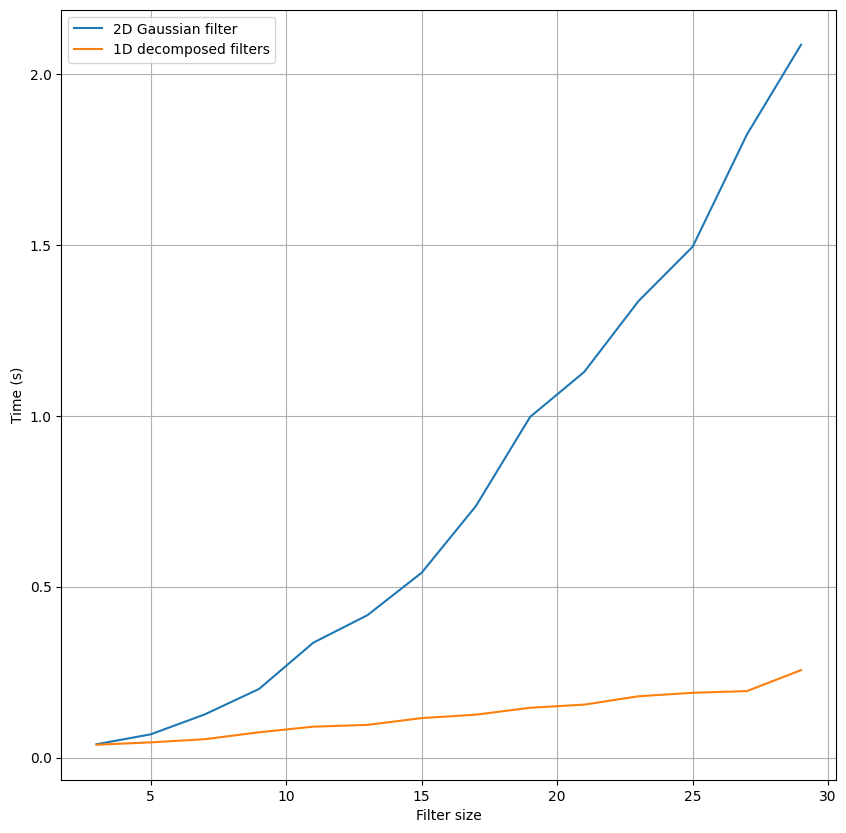

In [25]:
records = np.array(records)
plt.plot(filter_sizes, records[:,0], label='2D Gaussian filter')
plt.plot(filter_sizes, records[:,1], label='1D decomposed filters')
plt.legend()
plt.grid(True)
plt.ylabel('Time (s)')
plt.xlabel('Filter size')